In [9]:
# environment
!pip install diffusers==0.27.0 lpips datasets openai-clip huggingface-hub==0.23.4

In [10]:
try:
    import google.colab
    !git clone https://github.com/rhfeiyang/art-free-diffusion.git
    %cd /content/art-free-diffusion
except:
    pass

Cloning into 'art-free-diffusion'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 54 (delta 11), reused 51 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (54/54), 8.87 MiB | 10.34 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/art-free-diffusion


In [11]:
from diffusers import DiffusionPipeline
import matplotlib.pyplot as plt
import torch

First get access permission of https://huggingface.co/rhfeiyang/art-free-diffusion-v1

And fill in your HF_TOKEN here:

In [12]:
import os
os.environ["HF_TOKEN"] = ""

In [8]:
# Load our art-free diffusion model
pipe = DiffusionPipeline.from_pretrained("rhfeiyang/art-free-diffusion-v1").to("cuda")

model_index.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/374 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/810 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/828 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

tokenizer/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

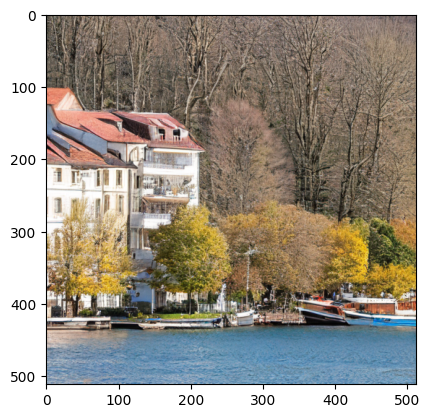

In [13]:
images = pipe("The image depicts a picturesque small town by a river, featuring several docked boats. Surrounded by trees, the town is near a large body of water, highlighting its popularity for boating and water activities. The serene composition, with trees and boats, underscores the town's natural beauty and tranquil charm.",
              num_inference_steps=50, guidance_scale=7.5, generator = torch.Generator().manual_seed(0)
              ).images
plt.imshow(images[0])

Download the Art Adapters

In [14]:
from data.download import download_data
download_data(["art_adapters"], "data")


Art_adapters.zip:   0%|          | 0.00/32.3M [00:00<?, ?B/s]

Extracting data/Art_adapters.zip


In [15]:
from inference import get_lora_network, inference, get_validation_dataloader
def demo_inference_gen(adapter_path:str, prompts:list, seed:int=0):
    infer_loader = get_validation_dataloader(prompts)
    network = get_lora_network(pipe.unet, adapter_path,"all_up")["network"]
    pred_images = inference(network, pipe.tokenizer, pipe.text_encoder, pipe.vae, pipe.unet, pipe.scheduler, infer_loader,
                            height=512, width=512, scales=[0.,1.],
                            save_dir=None, seed=seed,steps=50, guidance_scale=7.5,
                            start_noise=-1, show=True, style_prompt="sks art", no_load=True,
                            from_scratch=True)
    return pred_images

def demo_inference_stylization(adapter_path:str, prompts:list, image:list, start_noise=800,seed:int=0):
    infer_loader = get_validation_dataloader(prompts, image)
    network = get_lora_network(pipe.unet, adapter_path,"all_up")["network"]
    pred_images = inference(network, pipe.tokenizer, pipe.text_encoder, pipe.vae, pipe.unet, pipe.scheduler, infer_loader,
                            height=512, width=512, scales=[0.,1.],
                            save_dir=None, seed=seed,steps=50, guidance_scale=7.5,
                            start_noise=start_noise, show=True, style_prompt="sks art", no_load=True,
                            from_scratch=False)
    return pred_images


Art of Derain: Art generation

Rank: 1, Alpha: 1.0
create LoRA for U-Net: 123 modules.
Missing: <All keys matched successfully>
save dir: None


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/content/art-free-diffusion/inference.py:193: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. 

['Park with cherry blossom trees, picnicker’s and a clear blue pond in the style of sks art'], seed=0


100%|██████████| 51/51 [00:25<00:00,  1.96it/s]


Time taken for one batch, Art Adapter scale=0.0: 26.815383434295654


100%|██████████| 51/51 [00:27<00:00,  1.84it/s]


Time taken for one batch, Art Adapter scale=1.0: 28.602489948272705


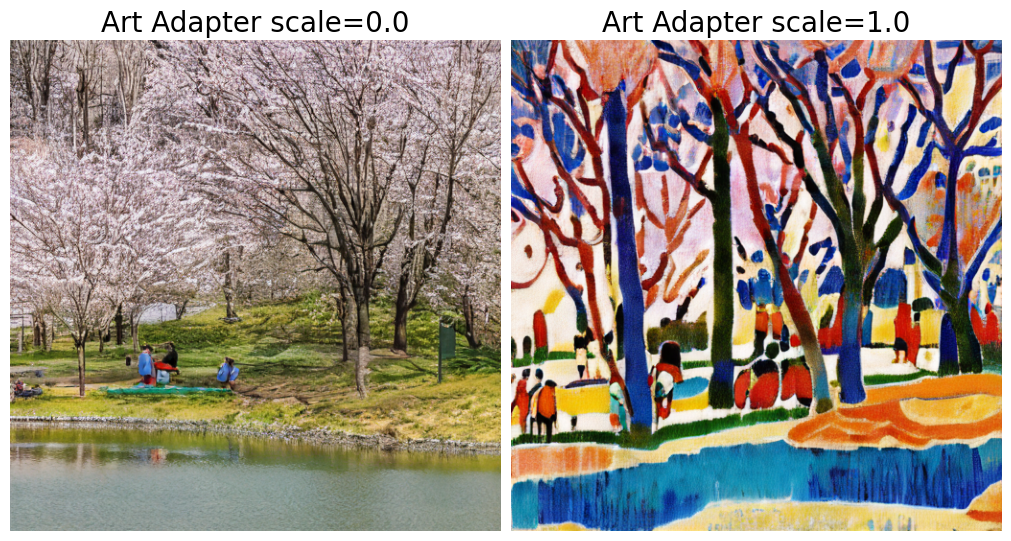

({0.0: [<PIL.Image.Image image mode=RGB size=512x512>],
  1.0: [<PIL.Image.Image image mode=RGB size=512x512>]},
 ['Park with cherry blossom trees, picnicker’s and a clear blue pond in the style of sks art'])

In [16]:
art_adapter_path="data/Art_adapters/andre-derain_subset1/adapter_alpha1.0_rank1_all_up_1000steps.pt"
infer_prompts=["Park with cherry blossom trees, picnicker’s and a clear blue pond."]
demo_inference_gen(art_adapter_path, infer_prompts, seed=0)

Art of Derain: Image Stylization

Rank: 1, Alpha: 1.0
create LoRA for U-Net: 123 modules.
Missing: <All keys matched successfully>
save dir: None
['Snow-covered trees with sunlight shining through in the style of sks art'], seed=0


100%|██████████| 51/51 [00:22<00:00,  2.24it/s]


Time taken for one batch, Art Adapter scale=0.0: 23.587342500686646


100%|██████████| 51/51 [00:22<00:00,  2.29it/s]


Time taken for one batch, Art Adapter scale=1.0: 23.03278350830078


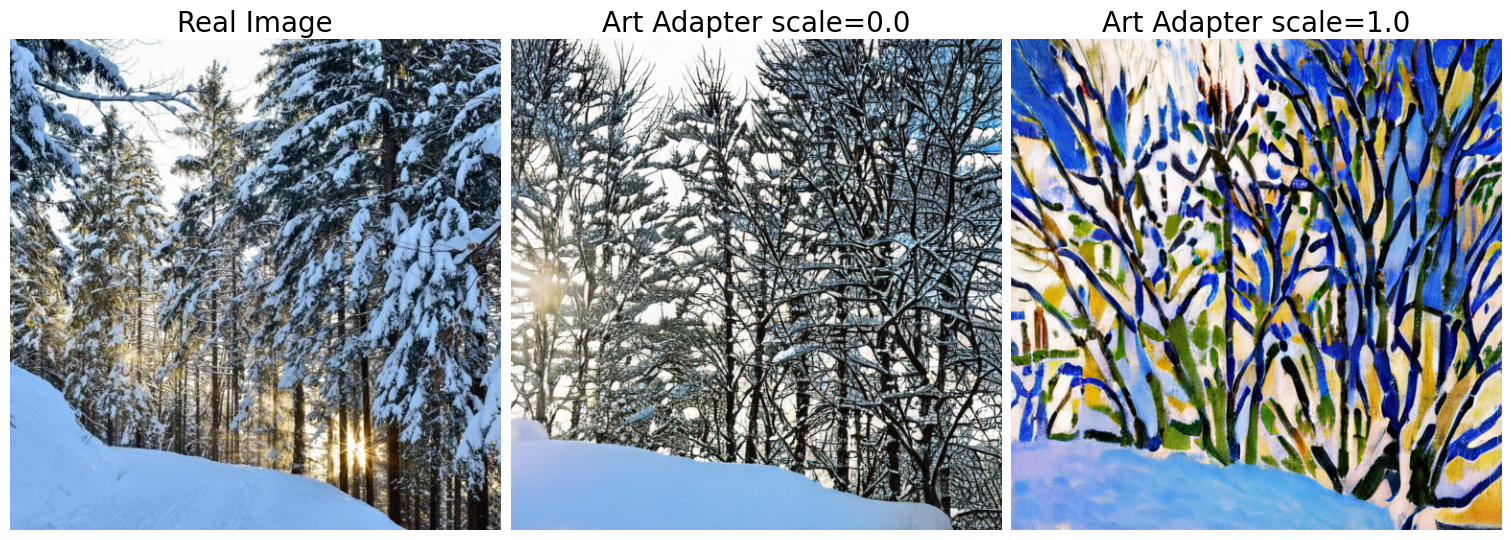

({'Real Image': [<PIL.Image.Image image mode=RGB size=512x512>],
  0.0: [<PIL.Image.Image image mode=RGB size=512x512>],
  1.0: [<PIL.Image.Image image mode=RGB size=512x512>]},
 ['Snow-covered trees with sunlight shining through in the style of sks art'])

In [17]:
art_adapter_path="data/Art_adapters/andre-derain_subset1/adapter_alpha1.0_rank1_all_up_1000steps.pt"
infer_prompts=["Snow-covered trees with sunlight shining through"]
ref_image=["demo_img/Snow-covered_trees_with_sunlight_shining_through.jpg"]
# the larger start_noise is, the more content changes, the more stylized the image is
demo_inference_stylization(art_adapter_path, infer_prompts, ref_image, start_noise=800, seed=0)